# Calculate cost savings from switching to generic equivalent presentations, across entire dataset

We wanted to examine the potential cost savings from switching from branded presentations of a chemical to the equivalent generic form. 

This can be done by using BNF codes to match each branded presentation with its generic equivalent, where available. 

This savings analysis makes the following assumptions: 

- there is no valid medical reason to prescribe the branded rather than the generic version of a chemical
- our use of `AA` in characters 10/11 of BNF codes to identify branded presentations is correct, and the generic equivalent can be found by matching the last four characters of the BNF code (as per [the BSA's glossary](http://www.nhsbsa.nhs.uk/PrescriptionServices/Documents/PrescriptionServices/PCA_Glossary_V1.doc))
- the active dose delivered in a generic tablet is equivalent to the active dose in a branded tablet - this seems likely.


We think we can identify branded presentations by looking for presentations with `AA` in characters 10 and 11.

We find the generic equivalent of those branded presentations, where available, by looking for presentations with the same chemical codes (first 9 characters) and format codes (last 4 characters), but with anything other than `AA` in characters 10 and 11. 

Note our method only matches precise generic equivalents, as the table shows - so if there's a 300mg branded tablet but only 200mg generic tablet, the 300mg branded tablet will appear to have no match. This means that the savings generated by our method will be lower than the "real" savings. We just have to live with this. 

## Number crunching

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set_style("darkgrid")

dates = ['15_10','15_11','15_12','16_01','16_02','16_03','16_04','16_05','16_06','16_07','16_08','16_09']
dataframes = [None]*12
i = 0
for date in dates:
    # Get data
    df0 = pd.read_csv('data/data_%s~' % date)

    # Find generic equivalents
    df0['chemical'] = df0['bnf_code'].str[:9] 
    df0['is_generic'] = (df0['bnf_code'].str[9:11] == 'AA')
    df0['format'] = df0['bnf_code'].str[11:] 

    # Get all non-generic presentations, and their
    # generic equivalents where available. 
    groups = df0.groupby('is_generic')
    df1 = pd.merge(groups.get_group(False), groups.get_group(True), \
                   on=['practice', 'chemical', 'format'], how='left', \
                  suffixes=('_branded', '_generic'))
    df1.sort_values('bnf_code_branded', inplace=True)
    df1.drop(['is_generic_branded', 'is_generic_generic', 'format'], axis=1, inplace=True)

    # Create average cost per quantity
    cols = ['bnf_code_branded','cost_generic','quantity_generic']
    df_ave = df1[cols].groupby('bnf_code_branded').sum()
    df_ave['generic_cost_per_quant'] = df_ave['cost_generic'] / df_ave['quantity_generic']
    df_ave.drop(['cost_generic', 'quantity_generic'], axis=1, inplace=True)
    df_ave[~np.isfinite(df_ave)] = np.nan
    df1 = df1.merge(df_ave, how='left', left_on='bnf_code_branded', right_index=True)
    
    # Calculate savings
    df2 = df1[~df1.generic_cost_per_quant.isnull()] #.copy()
    #df2['generic_cost_per_quant'] = df2['cost_generic'] / df2['quantity_generic']
    df2['hypothetical_cost'] = df2['quantity_branded'] * df2['generic_cost_per_quant']
    df2['hypothetical_saving'] = df2['cost_branded'] - df2['hypothetical_cost']
    df2.sort_values('hypothetical_saving', inplace=True, ascending=True)
    df2 = df2[np.isfinite(df2['hypothetical_saving'])]
    df_ave[df1.isnull()] = 0
    df2 = df2.reset_index()

    #calc ratio of branded in 10th percentile
    df2['branded_proportion'] = df2['quantity_branded'] / (df2['quantity_branded'] + df2['quantity_generic'])
    df10c = df2.groupby('bnf_code_branded')['branded_proportion'].quantile(.1)
    df10c = pd.DataFrame({'bnf_code_branded':df10c.index, 'branded_proportion_10c':df10c.values})
    df10c = df10c.set_index('bnf_code_branded')
    df2 = df2.set_index('bnf_code_branded')
    df2 = df2.merge(df10c, how='left', left_index=True, right_index=True)
    #clear if performing better than 10pct
    mask = (df2['branded_proportion'] < df2['branded_proportion_10c'])
    df2.loc[mask, 'branded_proportion_10c'] = 1
    df2['hypothetical_saving_10c'] = df2['hypothetical_saving']*(1-df2['branded_proportion_10c'])
    df2 = df2.reset_index()
    #df2 = df2[df2['hypothetical_saving_10c'] > 1] #############change if you want to keep negative differences
    dataframes[i] = df2
    i += 1

C:\Users\ajwalker\Anaconda2\lib\site-packages\ipykernel\__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ajwalker\Anaconda2\lib\site-packages\ipykernel\__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ajwalker\Anaconda2\lib\site-packages\ipykernel\__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [2]:
df_all = pd.concat(dataframes)
df_all_not_agg = df_all
#df_all = df_all.groupby(['practice', 'bnf_code_branded','bnf_name_branded']).sum()
df_all = df_all.reset_index()
df_all.sort_values('hypothetical_saving_10c', inplace=True, ascending=False)
df_all['chemical'] = df_all['bnf_code_branded'].str[:9]

practices = pd.read_csv('data/practices_4.csv')
df_all = df_all.merge(practices, how='inner', left_on='practice', right_on='practice')

practice_totals = df_all.groupby('practice').sum()
practice_totals.sort_values('hypothetical_saving_10c', inplace=True, ascending=False)
pres_totals = df_all.groupby(['bnf_code_branded','bnf_name_branded']).sum()
pres_totals.sort_values('hypothetical_saving_10c', inplace=True, ascending=False)
chem_totals = df_all.groupby(['chemical']).sum()
chem_totals.sort_values('hypothetical_saving_10c', inplace=True, ascending=False)
top_3 = df_all.groupby('practice').head(3).groupby('practice').sum()[['hypothetical_saving_10c']]
top_3.sort_values('hypothetical_saving_10c', inplace=True, ascending=False)

In [3]:
df_all.describe()

,level_0,index,items_branded,cost_branded,quantity_branded,items_generic,cost_generic,quantity_generic,generic_cost_per_quant,hypothetical_cost,hypothetical_saving,branded_proportion,branded_proportion_10c,hypothetical_saving_10c
count,8.649019e+06,8.649019e+06,8.649019e+06,8.649019e+06,8.649019e+06,4.533346e+06,4.533346e+06,4.533346e+06,8.649019e+06,8.649019e+06,8.649019e+06,4.533320e+06,8.649019e+06,8.649019e+06
mean,3.643328e+05,2.152856e+06,3.069714e+00,8.338594e+01,1.712151e+02,1.655550e+01,1.335385e+02,6.986452e+02,6.974946e+00,7.741264e+01,5.973298e+00,3.673485e-01,2.434710e-01,5.387128e+00
std,2.106905e+05,1.239657e+06,5.497522e+00,1.781869e+02,5.256342e+02,5.497397e+01,3.195596e+02,2.239785e+03,3.145067e+01,1.770139e+02,3.695764e+01,2.566185e-01,2.257074e-01,3.183012e+01
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-02,0.000000e+00,5.000000e-03,0.000000e+00,-6.144551e+03,0.000000e+00,0.000000e+00,-3.010830e+03
25%,1.818745e+05,1.075709e+06,1.000000e+00,1.059000e+01,1.100000e+01,2.000000e+00,1.432000e+01,2.800000e+01,8.624826e-02,6.871479e+00,-2.335478e-04,1.428571e-01,1.000000e-01,-9.561287e-05
50%,3.643170e+05,2.155915e+06,1.000000e+00,2.794000e+01,5.600000e+01,4.000000e+00,4.200000e+01,1.200000e+02,4.583338e-01,2.207287e+01,1.527667e-13,3.333333e-01,1.898810e-01,8.526513e-15
75%,5.459250e+05,3.231292e+06,3.000000e+00,7.791000e+01,1.250000e+02,1.100000e+01,1.215500e+02,4.760000e+02,4.489729e+00,6.746006e+01,5.854952e-01,5.423729e-01,2.857143e-01,1.807692e-01
max,7.439720e+05,4.372993e+06,2.184000e+03,1.817088e+04,8.060500e+04,3.727000e+03,1.835800e+04,1.999330e+05,1.105000e+03,1.817088e+04,5.938494e+03,1.000000e+00,1.000000e+00,5.873236e+03


In [4]:
print "Items prescribed on branded where generic switches available: %s" % \
    "{:,.0f}".format(df_all['items_branded'].sum())
print "Spending on branded where cheaper alternative switches available: £%s" % \
    "{:,.0f}".format(df_all['cost_branded'].sum())
print "Saving without 10pc adjustment: £%s" % \
    "{:,.0f}".format(df_all['hypothetical_saving'].sum())

print "Saving from switching to cheaper alternative, with 10th centile as target, top 3 savings: £%s" % \
    "{:,.0f}".format(df_all.groupby('practice').head(3)['hypothetical_saving_10c'].sum())
print "Saving from top 10 presentations: £%s" % \
    "{:,.0f}".format(chem_totals.head(10)['hypothetical_saving_10c'].sum())
table = {}
i=0
temp = df_all_not_agg['hypothetical_saving_10c'][df_all_not_agg['hypothetical_saving_10c'] < -1]
table[i] = ["Actions carrying additional cost",
            "£%s" % "{:,.0f}".format(temp.sum()),
            "%s" % "{:,.0f}".format(len(temp)),
            "£%s" % "{:,.0f}".format(temp.median())]
i +=1
for p in [-10000000000000000000,1, 50, 100, 500, 1000]:
    temp = df_all_not_agg['hypothetical_saving_10c'][df_all_not_agg['hypothetical_saving_10c'] > p]
    table[i] = [
        "Savings over £" + str(p) + "/practice/month",
        "£%s" % "{:,.0f}".format(temp.sum()),
        "%s" % "{:,.0f}".format(len(temp)),
        "£%s" % "{:,.0f}".format(temp.median())]
    i +=1
temp = df_all_not_agg['hypothetical_saving_10c'][df_all_not_agg['hypothetical_saving_10c'] < 0]
table[i] = ["Negative savings",
            "£%s" % "{:,.0f}".format(temp.sum()),
            "%s" % "{:,.0f}".format(len(temp)),
            "£%s" % "{:,.0f}".format(temp.median())]


display(pd.DataFrame.from_dict(table, orient='index').reset_index().sort_values('index'))

pd.options.display.float_format = '{:,.2f}'.format

display(practice_totals[['items_branded','hypothetical_saving_10c']].head(10))
print len(practice_totals)
display(pres_totals[['items_branded','hypothetical_saving_10c']].head(10))
print len(pres_totals)
display(chem_totals[['hypothetical_saving_10c']].head(10))
print len(chem_totals)


Items prescribed on branded where generic switches available: 26,550,014
Spending on branded where cheaper alternative switches available: £721,206,539
Saving without 10pc adjustment: £51,663,172
Saving from switching to cheaper alternative, with 10th centile as target, top 3 savings: £5,695,581
Saving from top 10 presentations: £29,774,899


,index,0,1,2,3
0,0,Actions carrying additional cost,"£-9,478,849","703,421",£-4
1,1,Savings over £-10000000000000000000/practice/m...,"£46,778,405","8,763,985",£0
2,2,Savings over £1/practice/month,"£56,281,590","1,828,802",£13
3,3,Savings over £50/practice/month,"£34,769,194","298,094",£82
4,4,Savings over £100/practice/month,"£21,852,642","112,701",£150
5,5,Savings over £500/practice/month,"£2,467,055","3,167",£636
6,6,Savings over £1000/practice/month,"£733,262",476,"£1,311"
7,7,Negative savings,"£-9,717,023","3,208,618",£-0


,items_branded,hypothetical_saving_10c
practice,,
C83039,15344,"112,380.35"
M85063,40819,"110,314.14"
D83005,12906,"75,190.67"
M82017,10892,"70,651.00"
D83029,11094,"62,012.52"
K84012,8558,"59,150.08"
C83019,19898,"49,810.61"
L82048,4947,"45,090.36"
C86019,12465,"44,323.78"


7808


,,items_branded,hypothetical_saving_10c
bnf_code_branded,bnf_name_branded,,
0408010A0BBABAB,Keppra_Tab 500mg,86403,"4,967,414.26"
0703021Q0BBAAAA,Cerazette_Tab 75mcg,390446,"3,621,273.33"
0408010A0BBACAC,Keppra_Tab 1g,44549,"3,588,254.02"
0301020S0BBAAAA,Seebri_Breezhaler Inh Cap 55mcg + Dev,235581,"2,446,968.54"
0106040M0BBAAAA,Movicol_Pdr Sach 13.8g (Lem & Lim),446280,"1,956,671.56"
0408010A0BBAAAA,Keppra_Tab 250mg,54129,"1,611,482.30"
1106000L0BBAAAA,Xalatan_Eye Dps 50mcg/ml,97155,"1,543,683.87"
0802010M0BBABAB,CellCept_Tab 500mg,13321,"1,498,521.73"
0103050P0BBAAAA,Losec_Cap E/C 20mg,62202,"1,294,392.39"


1573


,hypothetical_saving_10c
chemical,
0408010A0,"10,167,150.59"
0703021Q0,"4,954,533.23"
0212000B0,"2,543,826.31"
0301020S0,"2,446,968.54"
0106040M0,"1,967,845.51"
0103050E0,"1,923,455.60"
1106000L0,"1,543,683.87"
0802010M0,"1,498,519.53"
0407041T0,"1,395,149.66"


802


### Figure 1

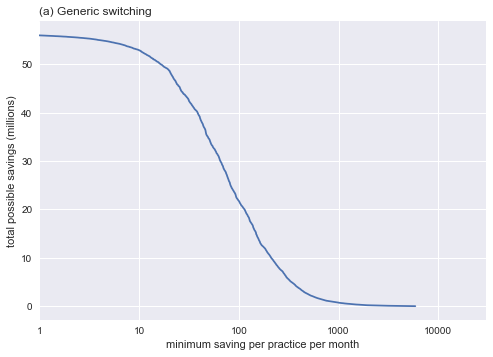

In [5]:
#pd.set_option('display.float_format', lambda x: "{:,.2f}".format(x))

df_all.sort_values('hypothetical_saving_10c', inplace=True, ascending=False)

df_all['cum_sum'] = df_all['hypothetical_saving_10c'].cumsum()/1000000
fig, ax = plt.subplots()
ax.plot(df_all['hypothetical_saving_10c'],df_all['cum_sum'])
ax.set_xscale("log")
ax.set_xlim(1,30000)
ax.set_xlabel('minimum saving per practice per month')
ax.set_ylabel('total possible savings (millions)')
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%0.0f'))
ax.set_title('(a) Generic switching',loc='left')
plt.show()
df_all['cum_sum'].tail(1)
df_all[['hypothetical_saving_10c','cum_sum']].to_csv('graph.csv')

### Figure 2(a)

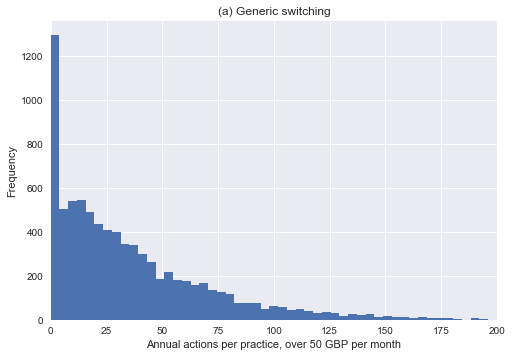

,(a) Generic switching
count,"8,180.00"
mean,36.34
std,36.47
min,0.00
5%,0.00
50%,26.00
95%,109.05
max,362.00


In [6]:
practices = pd.read_csv('data/practices_4.csv')
df_hist = df_all.loc[df_all.hypothetical_saving_10c>50].groupby('practice').size()
df_hist = df_hist.to_frame(name='(a) Generic switching')
df_hist = df_hist.merge(practices, how='right', left_index=True, right_on='practice')
df_hist = df_hist.fillna(0)
df_hist.loc[df_hist['(a) Generic switching']<200].hist(bins=50)
plt.xlim(0,200)
plt.xlabel('Annual actions per practice, over 50 GBP per month')
plt.ylabel('Frequency')
#plt.title('(a) Generic switching',loc='left')
plt.show()
df_hist.to_csv('hist.csv')
df_hist.describe(percentiles=[.05,.5,.95])

### Number of practices with no actions

In [7]:
len(df_hist.loc[df_hist['(a) Generic switching']==0])

810

### Figure 3

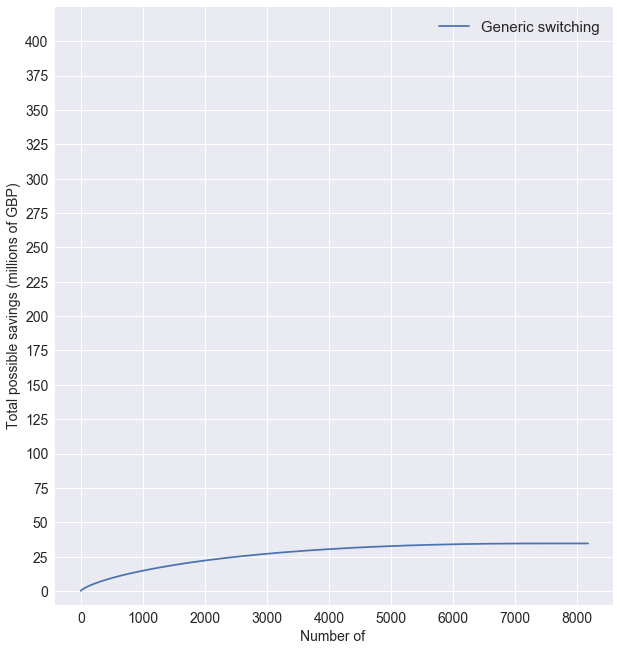

In [8]:
sums = df_all.loc[df_all.hypothetical_saving_10c>50].groupby('practice').sum()
#sums = df_all.groupby('practice').sum()
sums = sums.merge(practices, how='right', left_index=True, right_on='practice')
sums = sums.fillna(0)
sums.sort_values('hypothetical_saving_10c', inplace=True, ascending=False)

sums['cum_sum2'] = sums['hypothetical_saving_10c'].cumsum()/1000000
sums.to_csv('graph2.csv')


fig, ax = plt.subplots(figsize=(10, 11))
generic_comp = pd.read_csv('graph2.csv')
ax.plot(range(len(sums)),
        generic_comp['cum_sum2'],
        label='Generic switching')


ax.yaxis.set_ticks(range(0,425,25))
ax.set_ylim(-10,425)
ax.set_xlabel('Number of ')
ax.set_ylabel('Total possible savings (millions of GBP)')

ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%0.0f'))
ax.legend(fontsize=15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()